# Fish data

In [2]:
import os
import pandas as pd
import sys
from eks.utils import *
from eks.multiview_pca_smoother import *
from eks.newton_eks import *
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm.notebook as tqdm
from eks.video import get_frames_from_idxs, save_video
from scipy.optimize import *
import scipy as sp

In [171]:
import numpy
import cv2
from matplotlib.gridspec import GridSpec
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from collections import defaultdict
import shutil

In [4]:
labeled_new = pd.read_csv("data/mirror-fish/CollectedData_new.csv", header = [0,1,2], index_col=0)

In [5]:
labeled_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 94 entries, labeled-data/20210126_Sean/img001058.png to labeled-data/20210204_Quin/img197707.png
Data columns (total 90 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   (rick, head_main, x)        94 non-null     float64
 1   (rick, head_main, y)        94 non-null     float64
 2   (rick, chin_base_main, x)   91 non-null     float64
 3   (rick, chin_base_main, y)   91 non-null     float64
 4   (rick, chin1_4_main, x)     90 non-null     float64
 5   (rick, chin1_4_main, y)     90 non-null     float64
 6   (rick, chin_half_main, x)   91 non-null     float64
 7   (rick, chin_half_main, y)   91 non-null     float64
 8   (rick, chin3_4_main, x)     92 non-null     float64
 9   (rick, chin3_4_main, y)     92 non-null     float64
 10  (rick, chin_tip_main, x)    92 non-null     float64
 11  (rick, chin_tip_main, y)    92 non-null     float64
 12  (rick, mid_main, x)   

In [29]:
labeled = pd.read_csv("data/mirror-fish/CollectedData.csv", header = [0,1,2], index_col=0)

<Axes: xlabel='scorer-bodyparts-coords'>

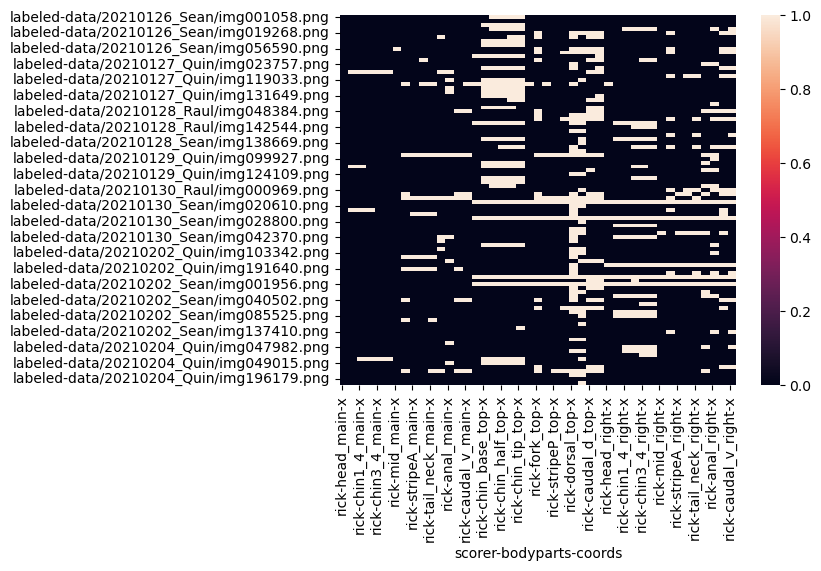

In [132]:
sns.heatmap(labeled_new.isna())

In [144]:
(1-np.sum(labeled_new.isna())/len(labeled_new))[:20]

scorer  bodyparts       coords
rick    head_main       x         1.000000
                        y         1.000000
        chin_base_main  x         0.968085
                        y         0.968085
        chin1_4_main    x         0.957447
                        y         0.957447
        chin_half_main  x         0.968085
                        y         0.968085
        chin3_4_main    x         0.978723
                        y         0.978723
        chin_tip_main   x         0.978723
                        y         0.978723
        mid_main        x         0.989362
                        y         0.989362
        fork_main       x         0.904255
                        y         0.904255
        stripeA_main    x         0.946809
                        y         0.946809
        stripeP_main    x         0.925532
                        y         0.925532
dtype: float64

In [12]:
from eks.utils import convert_lp_dlc
from eks.multiview_pca_smoother import ensemble_kalman_smoother_multi_cam


camera_names = ['main', 'top', 'right']
keypoint_ensemble_list = [
    'head', 'chin_base', 'chin1_4', 'chin_half','chin3_4', 'chin_tip', 'mid', 'fork',
    'stripeA', 'stripeP', 'tail_neck', 'dorsal', 'anal', 'caudal_d', 'caudal_v',
]
tracker_name = 'heatmap_mhcrnn_tracker'
num_cameras = len(camera_names)

# NOTE! replace this path with an absolute path where you want to save EKS outputs
eks_save_dir = '/Users/clairehe/Documents/GitHub/eks/data/misc/one-video-mirror-fish-predictions/eks_opti/'

# path for prediction csvs
file_path = '/Users/clairehe/Documents/GitHub/eks/data/misc/mirror-fish_ensemble-predictions'

# NOTE! replace these paths with the absolute paths to prediction csvs on your local computer
model_dirs = [
    file_path+"/network_0",
    file_path+"/network_1",
    file_path+"/network_2",
    file_path+"/network_3",
    file_path+"/network_4",
]


In [13]:
def profile_plot(baseline, pathfile, operator, name):

    fig,ax = plt.subplots(2,2,figsize=(12,10))

    #ax[0,0].plot(new.caudal_d_right[["x"]], color='black')
    ax[0,0].plot(baseline.caudal_d_right[["x"]], 'r--',label='baseline' )
    ax[0,0].plot(pd.read_csv(pathfile+"network_0"+operator+name+".csv", header=[1,2]).caudal_d_right[["x"]], color='gray')
    ax[0,0].plot(pd.read_csv(pathfile+"network_1"+operator+name+".csv", header=[1,2]).caudal_d_right[["x"]], color='gray')
    ax[0,0].plot(pd.read_csv(pathfile+"network_2"+operator+name+".csv", header=[1,2]).caudal_d_right[["x"]], color='gray')
    ax[0,0].plot(pd.read_csv(pathfile+"network_3"+operator+name+".csv", header=[1,2]).caudal_d_right[["x"]], color='gray')
    ax[0,0].plot(pd.read_csv(pathfile+"network_4"+operator+name+".csv", header=[1,2]).caudal_d_right[["x"]], color='gray')
    ax[0,0].set_ylabel("x coords")
    ax[0,0].set_title("caudal_d right")
    ax[0,0].legend(['baseline eks', 'individual models'])

    #ax[0,1].plot(new.caudal_d_right[["y"]], color='black')
    ax[0,1].plot(baseline.caudal_d_right[["y"]], 'r--',label='baseline')
    ax[0,1].plot(pd.read_csv(pathfile+"network_0"+operator+name+".csv", header=[1,2]).caudal_d_right[["y"]], color='gray')
    ax[0,1].plot(pd.read_csv(pathfile+"network_1"+operator+name+".csv", header=[1,2]).caudal_d_right[["y"]], color='gray')
    ax[0,1].plot(pd.read_csv(pathfile+"network_2"+operator+name+".csv", header=[1,2]).caudal_d_right[["y"]], color='gray')
    ax[0,1].plot(pd.read_csv(pathfile+"network_3"+operator+name+".csv", header=[1,2]).caudal_d_right[["y"]], color='gray')
    ax[0,1].plot(pd.read_csv(pathfile+"network_4"+operator+name+".csv", header=[1,2]).caudal_d_right[["y"]], color='gray')
    ax[0,1].set_title("caudal_d right")
    ax[0,1].set_ylabel("y coords")
    ax[0,1].legend(['baseline eks', 'individual models'])

    #ax[1,0].plot(new.chin_tip_right[["x"]], color='black')
    ax[1,0].plot(baseline.chin_tip_right[["x"]], 'r--',label='baseline')
    ax[1,0].plot(pd.read_csv(pathfile+"network_0"+operator+name+".csv", header=[1,2]).chin_tip_right[["x"]], color='gray')
    ax[1,0].plot(pd.read_csv(pathfile+"network_1"+operator+name+".csv", header=[1,2]).chin_tip_right[["x"]], color='gray')
    ax[1,0].plot(pd.read_csv(pathfile+"network_2"+operator+name+".csv", header=[1,2]).chin_tip_right[["x"]], color='gray')
    ax[1,0].plot(pd.read_csv(pathfile+"network_3"+operator+name+".csv", header=[1,2]).chin_tip_right[["x"]], color='gray')
    ax[1,0].plot(pd.read_csv(pathfile+"network_4"+operator+name+".csv", header=[1,2]).chin_tip_right[["x"]], color='gray')
    ax[1,0].set_title("chin_tip right")
    ax[1,0].set_ylabel("x coords")
    ax[1,0].legend(['baseline eks', 'individual models'])

    #ax[1,1].plot(new.chin_tip_right[["y"]],color='black')
    ax[1,1].plot(baseline.chin_tip_right[["y"]], 'r--',label='baseline')
    ax[1,1].plot(pd.read_csv(pathfile+"network_0"+operator+name+".csv", header=[1,2]).chin_tip_right[["y"]], color='gray')
    ax[1,1].plot(pd.read_csv(pathfile+"network_1"+operator+name+".csv", header=[1,2]).chin_tip_right[["y"]], color='gray')
    ax[1,1].plot(pd.read_csv(pathfile+"network_2"+operator+name+".csv", header=[1,2]).chin_tip_right[["y"]], color='gray')
    ax[1,1].plot(pd.read_csv(pathfile+"network_3"+operator+name+".csv", header=[1,2]).chin_tip_right[["y"]], color='gray')
    ax[1,1].plot(pd.read_csv(pathfile+"network_4"+operator+name+".csv", header=[1,2]).chin_tip_right[["y"]], color='gray')
    ax[1,1].set_title("chin_tip right")
    ax[1,1].set_ylabel("y coords")
    ax[1,1].legend(['baseline eks', 'individual models'])

    plt.suptitle("Video {}".format(name))

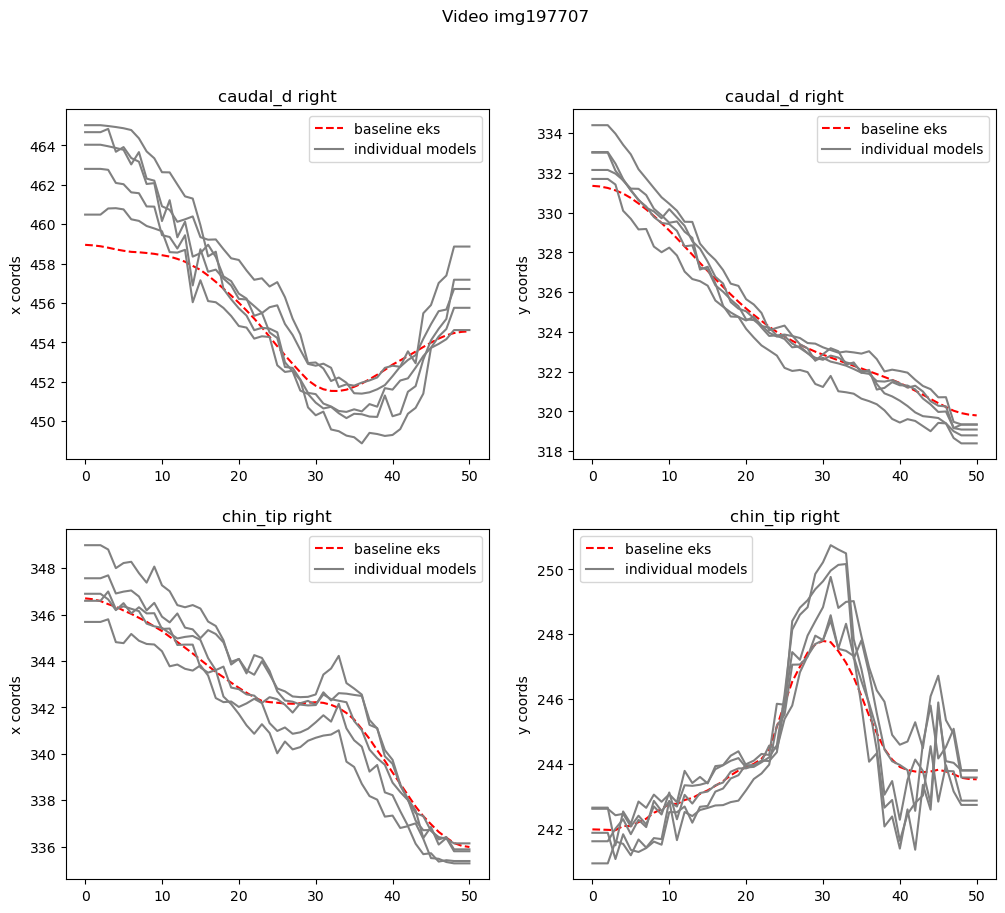

In [14]:
folder = "/eks_opti"
operator = "/20210204_Quin/"
name = "img197707"

baseline = pd.read_csv("/Users/clairehe/Documents/GitHub/eks/data/misc/mirror-fish_ensemble-predictions/eks"+operator+name+".csv", header=[ 1, 2],index_col=0)
#new = pd.read_csv("/Users/clairehe/Documents/GitHub/eks/data/misc/one-video-mirror-fish-predictions"+folder+operator+name, header=[ 1, 2], index_col=0)
baseline0 = pd.read_csv("/Users/clairehe/Documents/GitHub/eks/data/misc/mirror-fish_ensemble-predictions/eks"+operator+name+".csv", header=[0, 1, 2],index_col=0)

keypoint_names = [l[1] for l in baseline0.columns[::3]]
markers_tmp = convert_lp_dlc(baseline0, keypoint_names, model_name=tracker_name)
markers_tmp.head()
pathfile = "/Users/clairehe/Documents/GitHub/eks/data/misc/mirror-fish_ensemble-predictions/"
profile_plot(baseline, pathfile, operator, name)

In [40]:
lab_points = labeled.loc["labeled-data"+operator+name+".png"]
lab_points

scorer  bodyparts       coords
rick    head_main       x         193.333333
                        y         253.333333
        chin_base_main  x         214.444444
                        y         232.222222
        chin1_4_main    x         217.777778
                                     ...    
        anal_right      y         309.444444
        caudal_d_right  x         453.840000
                        y         321.320000
        caudal_v_right  x         433.888889
                        y         343.333333
Name: labeled-data/20210204_Quin/img197707.png, Length: 90, dtype: float64

In [409]:
for parts in bodyparts:
    if "head" in parts:
        print(parts)

head_main
head_top
head_right


In [545]:
bodyparts = []
m = lab_points["rick"].index
for i in range(len(lab_points["rick"])):
    if m[i][1] == 'x':
        bodyparts.append(m[i][0])
    else:
        pass

In [546]:
lab_points["rick"][bodyparts[0]]

coords
x    193.333333
y    253.333333
Name: labeled-data/20210204_Quin/img197707.png, dtype: float64

In [119]:
keys = ["_main","_top","_right"]

Text(0.5, 0.98, 'labeled img197707')

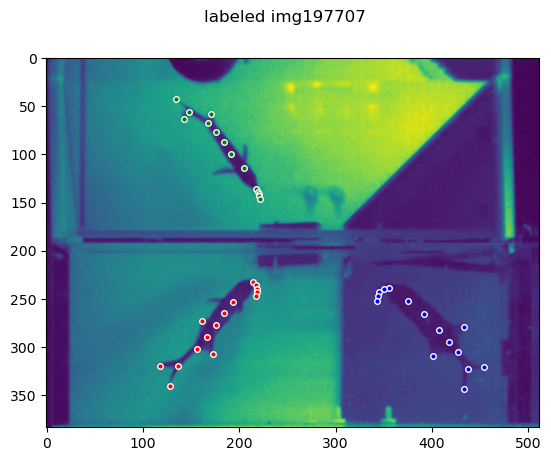

In [123]:
marker_shapes = 'o'
model_colors = ['red','green','blue']

fig,ax = plt.subplots()
for j, part in enumerate(bodyparts):
    for i, key in enumerate(keys):
        if key in part:
            ax.plot(lab_points["rick"][part][0],lab_points["rick"][part][1], marker_shapes, markeredgecolor='w', markersize=4, 
                color=model_colors[i])

image_path = "data/mirror-fish/labeled-data"
im = plt.imread(image_path+operator+name+".png")
plt.imshow(im)
plt.suptitle("labeled "+name)


In [293]:
def plot_bodyparts(ax, data, bodyparts, marker_shape='o', label = False):
    model_colors = ['red','green','blue']

    for j, part in enumerate(bodyparts):
        for i, key in enumerate(keys):
            if key in part:
                ax.plot(data[part]["x"],data[part]["y"], marker_shape, markeredgecolor='w', markersize=4, 
                    color=model_colors[i])
    if label == True:
        image_path = "data/mirror-fish/labeled-data"
        im = plt.imread(image_path+operator+name+".png")
        plt.imshow(im)
    plt.suptitle("parts "+name)

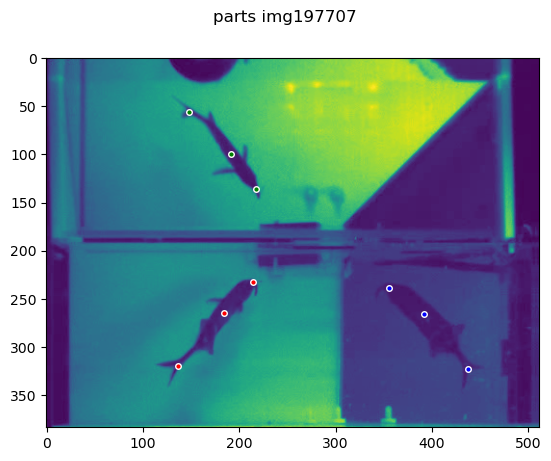

In [294]:
fig,ax = plt.subplots()
bodypart = ["chin_base_main", "mid_main","fork_main","chin_base_top", "mid_top","fork_top","chin_base_right", "mid_right","fork_right"]
plot_bodyparts(ax, lab_points["rick"],bodypart, label=True)

Get the distance constraints: chin_base/fork, chin_base/mid_main

In [302]:
lab_points["rick"][["chin_base_main","mid_main","fork_main"]]
def get_2pt_distance(data, part1, part2):
    point1 = np.asarray(data[[part1]])
    point2 = np.asarray(data[[part2]])
    return np.sqrt(np.sum(point1 - point2)**2)

In [303]:
chin_mid = get_2pt_distance(lab_points["rick"],"chin_base_main","mid_main")
fork_mid = get_2pt_distance(lab_points["rick"],"fork_main","mid_main")
chin_fork = get_2pt_distance(lab_points["rick"],"chin_base_main","fork_main")

Text(0.5, 0.98, 'img197707')

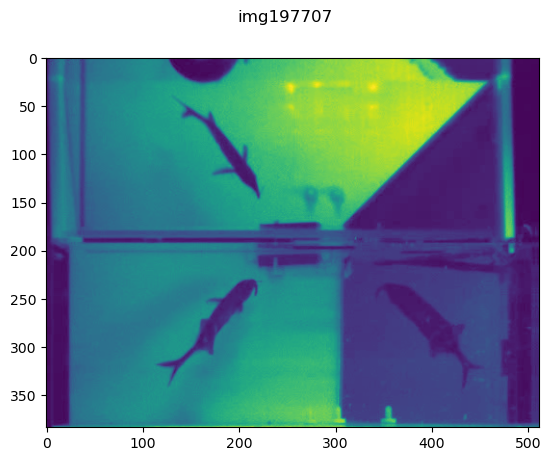

In [17]:
image_path = "data/mirror-fish/labeled-data"
im = plt.imread(image_path+operator+name+".png")
plt.imshow(im)
plt.suptitle(name)

In [23]:
def get_frames_from_idxs(cap, idxs):
    """Helper function to load video segments.
    Parameters
    ----------
    cap : cv2.VideoCapture object
    idxs : array-like
        frame indices into video
    Returns
    -------
    np.ndarray
        returned frames of shape shape (n_frames, n_channels, ypix, xpix)
    """
    is_contiguous = np.sum(np.diff(idxs)) == (len(idxs) - 1)
    n_frames = len(idxs)
    for fr, i in enumerate(idxs):
        if fr == 0 or not is_contiguous:
            cap.set(1, i)
        ret, frame = cap.read()
        if ret:
            if fr == 0:
                height, width, _ = frame.shape
                frames = np.zeros((n_frames, 1, height, width), dtype='uint8')
            frames[fr, 0, :, :] = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            return frames
        else:
            print(
                'warning! reached end of video; returning blank frames for remainder of ' +
                'requested indices')
            break
    


In [786]:
eps = 10
def distance(a,b):
    return np.sqrt(np.sum((a-b)**2))
def investigate_constraint_cmf(bodypart, plot=False):
    new_chin_mid = []
    new_chin_fork = []
    new_mid_fork= []
    if plot:
        for n in range(50):
            fig,ax = plt.subplots()
            frame = get_frames_from_idxs(cap, [n])[0][0]
            plot_bodyparts(ax,baseline.iloc[n],bodypart)
            plot_bodyparts(ax,lab_points["rick"],bodypart,marker_shape='x')
            new_chin_mid.append(get_2pt_distance(baseline.iloc[n],"chin_base_main","mid_main"))
            new_chin_fork.append(get_2pt_distance(baseline.iloc[n],"chin_base_main","fork_main"))
            new_mid_fork.append(get_2pt_distance(baseline.iloc[n],"fork_main","mid_main"))
            ax.imshow(frame)
        plt.show()
    else:
        for n in range(50):
            new_chin_mid.append(get_2pt_distance(baseline.iloc[n],"chin_base_main","mid_main"))
            new_chin_fork.append(get_2pt_distance(baseline.iloc[n],"chin_base_main","fork_main"))
            new_mid_fork.append(get_2pt_distance(baseline.iloc[n],"fork_main","mid_main")) 
    
    new_distances = pd.DataFrame(data={'chin_mid':new_chin_mid,'chin_fork':new_chin_fork, 'mid_fork':new_mid_fork})
    print(distance(np.mean(new_chin_mid),chin_mid),distance(np.mean(new_chin_fork),chin_fork),distance(np.mean(new_mid_fork),fork_mid)) 
    return new_distances

In [789]:
new_distances = investigate_constraint_cmf(bodypart)

0.6718383566674362 0.26573541981919035 1.8237283149087826


In [384]:
chin_mid, chin_fork, fork_mid

(2.777777777777999, 9.65333333333399, 6.875555555555991)

In [519]:
new_distances.head()

,chin_mid,chin_fork,mid_fork
0,1.097943,11.482737,12.580680
1,1.093736,11.451163,12.544900
2,1.070695,11.386780,12.457475
3,1.005761,11.307099,12.312860
4,0.943315,11.165202,12.108517


<Axes: >

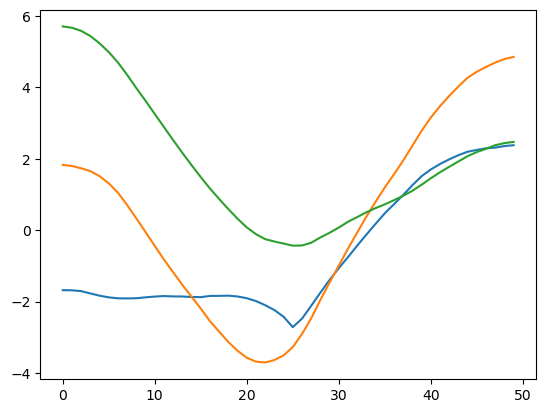

In [523]:
(new_distances.chin_mid - chin_mid).plot()
(new_distances.chin_fork - chin_fork).plot()
(new_distances.mid_fork - fork_mid).plot()

# Explore constraints

In [774]:
# -----------------------
# funcs for kalman paw
# -----------------------
def remove_camera_means(ensemble_stacks, camera_means):
    scaled_ensemble_stacks = ensemble_stacks.copy()
    for k in range(len(ensemble_stacks)):
        for camera_id, camera_mean in enumerate(camera_means):
            scaled_ensemble_stacks[k][:,camera_id] = ensemble_stacks[k][:,camera_id] - camera_mean
    return scaled_ensemble_stacks


def add_camera_means(ensemble_stacks, camera_means):
    scaled_ensemble_stacks = ensemble_stacks.copy()
    for k in range(len(ensemble_stacks)):
        for camera_id, camera_mean in enumerate(camera_means):
            scaled_ensemble_stacks[k][:,camera_id] = ensemble_stacks[k][:,camera_id] + camera_mean
    return scaled_ensemble_stacks


def pca(S, n_comps):
    pca_ = PCA(n_components=n_comps)
    return pca_.fit(S), pca_.explained_variance_ratio_



def ensemble_kalman_smoother_multi_cam(
        markers_list_cameras, keypoint_ensemble, smooth_param, quantile_keep_pca, camera_names):
# --------------------------------------------------------------
# interpolate right cam markers to left cam timestamps
# --------------------------------------------------------------
    num_cameras = len(camera_names)
    markers_list_stacked_interp = []
    markers_list_interp = [[] for i in range(num_cameras)]
    for model_id in range(len(markers_list_cameras[0])):
        bl_markers_curr = []
        camera_markers_curr = [[] for i in range(num_cameras)]
        for i in range(markers_list_cameras[0][0].shape[0]):
            curr_markers = []
            for camera in range(num_cameras):
                markers = np.array(markers_list_cameras[camera][model_id].to_numpy()[i, [0, 1]])
                camera_markers_curr[camera].append(markers)
                curr_markers.append(markers)
            bl_markers_curr.append(np.concatenate(curr_markers)) #combine predictions for both cameras
        markers_list_stacked_interp.append(bl_markers_curr)
        for camera in range(num_cameras):
            markers_list_interp[camera].append(camera_markers_curr[camera])
    markers_list_stacked_interp = np.asarray(markers_list_stacked_interp)
    markers_list_interp = np.asarray(markers_list_interp)

    keys = [keypoint_ensemble+'_x', keypoint_ensemble+'_y']
    markers_list_cams = [[] for i in range(num_cameras)]
    for k in range(len(markers_list_interp[0])):
        for camera in range(num_cameras):
            markers_cam = pd.DataFrame(markers_list_interp[camera][k], columns = keys)
            markers_list_cams[camera].append(markers_cam)

    #compute ensemble median for each camera
    cam_ensemble_preds = []
    cam_ensemble_vars = []
    cam_ensemble_stacks = []
    cam_keypoints_mean_dict = []
    cam_keypoints_var_dict = []
    cam_keypoints_stack_dict = []
    for camera in range(num_cameras):
        cam_ensemble_preds_curr, cam_ensemble_vars_curr, cam_ensemble_stacks_curr, cam_keypoints_mean_dict_curr, cam_keypoints_var_dict_curr, cam_keypoints_stack_dict_curr = ensemble(markers_list_cams[camera], keys)
        cam_ensemble_preds.append(cam_ensemble_preds_curr)
        cam_ensemble_vars.append(cam_ensemble_vars_curr)
        cam_ensemble_stacks.append(cam_ensemble_stacks_curr)
        cam_keypoints_mean_dict.append(cam_keypoints_mean_dict_curr)
        cam_keypoints_var_dict.append(cam_keypoints_var_dict_curr)
        cam_keypoints_stack_dict.append(cam_keypoints_stack_dict_curr)

    #filter by low ensemble variances
    hstacked_vars = np.hstack(cam_ensemble_vars)
    max_vars = np.max(hstacked_vars,1)
    quantile_keep = quantile_keep_pca
    good_frames = np.where(max_vars <= np.percentile(max_vars, quantile_keep))[0]

    good_cam_ensemble_preds = []
    good_cam_ensemble_vars = []
    for camera in range(num_cameras):
        good_cam_ensemble_preds.append(cam_ensemble_preds[camera][good_frames])
        good_cam_ensemble_vars.append(cam_ensemble_vars[camera][good_frames])

    good_ensemble_preds = np.hstack(good_cam_ensemble_preds)
    good_ensemble_vars = np.hstack(good_cam_ensemble_vars)
    means_camera = []
    for i in range(good_ensemble_preds.shape[1]):
        means_camera.append(good_ensemble_preds[:,i].mean())

    ensemble_preds = np.hstack(cam_ensemble_preds)
    ensemble_vars = np.hstack(cam_ensemble_vars)
    ensemble_stacks = np.concatenate(cam_ensemble_stacks,2)
    scaled_ensemble_stacks = remove_camera_means(ensemble_stacks, means_camera)

    good_scaled_ensemble_preds = remove_camera_means(good_ensemble_preds[None,:,:], means_camera)[0]
    ## PCA 
    ensemble_pca, ensemble_ex_var = pca(good_scaled_ensemble_preds, 3)

    scaled_ensemble_preds = remove_camera_means(ensemble_preds[None,:,:], means_camera)[0]
    ensemble_pcs = ensemble_pca.transform(scaled_ensemble_preds)
    good_ensemble_pcs = ensemble_pcs[good_frames]

    y_obs = scaled_ensemble_preds
    # print("input",y_obs.shape)
    
    #compute center of mass
    #latent variables (observed)
    good_z_t_obs = good_ensemble_pcs #latent variables - true 3D pca
    
    
    ##### Set values for kalman filter #####
    m0 = np.asarray([0.0, 0.0, 0.0]) # initial state: mean
    S0 =  np.asarray([[np.var(good_z_t_obs[:,0]), 0.0, 0.0], [0.0, np.var(good_z_t_obs[:,1]), 0.0], [0.0, 0.0, np.var(good_z_t_obs[:,2])]]) # diagonal: var

    A = np.asarray([[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]]) #state-transition matrix,
    # Q = np.asarray([[10.0, 0.0, 0.0], [0.0, 10.0, 0.0], [0.0, 0.0, 10.0]]) #state covariance matrix?????
    d_t = good_z_t_obs[1:] - good_z_t_obs[:-1]

    Q = smooth_param*np.cov(d_t.T)

    C = ensemble_pca.components_.T # Measurement function is inverse transform of PCA
    R = np.eye(ensemble_pca.components_.shape[1]) # placeholder diagonal matrix for ensemble variance

    print(f"filtering {keypoint_ensemble}...")
    mf, Vf, S = filtering_pass(y_obs, m0, S0, C, R, A, Q, ensemble_vars)
    print("done filtering")
    y_m_filt = np.dot(C, mf.T).T
    y_v_filt = np.swapaxes(np.dot(C, np.dot(Vf, C.T)), 0, 1)

    # Do the smoothing step
    print(f"smoothing {keypoint_ensemble}...")
    ms, Vs, _ = smooth_backward(y_obs, mf, Vf, S, A, Q, C)
    print("done smoothing")

    # Smoothed posterior over y
    y_m_smooth = np.dot(C, ms.T).T
    y_v_smooth = np.swapaxes(np.dot(C, np.dot(Vs, C.T)), 0, 1)
    
    pdindex = make_dlc_pandas_index([keypoint_ensemble])
    camera_indices = []
    for camera in range(num_cameras):
        camera_indices.append([camera*2, camera*2+1])
 
    camera_dfs = {}
    for camera, camera_name in enumerate(camera_names):
        var = np.empty(y_m_smooth.T[camera_indices[camera][0]].shape)
        var[:] = np.nan
        pred_arr = np.vstack([
            y_m_smooth.T[camera_indices[camera][0]] + means_camera[camera_indices[camera][0]],
            y_m_smooth.T[camera_indices[camera][1]] + means_camera[camera_indices[camera][1]],
            var,
        ]).T
        camera_dfs[camera_name + '_df'] = pd.DataFrame(pred_arr, columns=pdindex)

    return ms, ensemble_pca, ensemble_ex_var, camera_dfs



In [775]:
session = '20210204_Quin'

camera_names = ['main', 'top', 'right']
keypoint_ensemble_list = ['chin_base','fork']
    #'head', 'chin_base', 'chin1_4', 'chin_half','chin3_4', 'chin_tip', 'mid', 'fork',
    #'stripeA', 'stripeP', 'tail_neck', 'dorsal', 'anal', 'caudal_d', 'caudal_v',
    #]
tracker_name = 'heatmap_mhcrnn_tracker'
num_cameras = len(camera_names)

# NOTE! replace this path with an absolute path where you want to save EKS outputs
eks_save_dir = '/Users/clairehe/Documents/GitHub/eks/data/misc/one-video-mirror-fish-predictions/eks_outputs/'

# path for prediction csvs
file_path = '/Users/clairehe/Documents/GitHub/eks/data/misc/mirror-fish_ensemble-predictions'

# NOTE! replace these paths with the absolute paths to prediction csvs on your local computer
model_dirs = [
    file_path+"/network_0",
    file_path+"/network_1",
    file_path+"/network_2",
    file_path+"/network_3",
    file_path+"/network_4",
]
frame = "img197707.csv"
# extract all markers
markers_list = []
for model_dir in model_dirs:
    csv_file = os.path.join(model_dir, session, frame)
    df_tmp = pd.read_csv(csv_file, header=[0, 1, 2], index_col=0)
    keypoint_names = [l[1] for l in df_tmp.columns[::3]]
    markers_tmp = convert_lp_dlc(df_tmp, keypoint_names, model_name=tracker_name)
    markers_list.append(markers_tmp)
# make empty dataframe to write results into
df_eks = df_tmp.copy()
for col in df_eks.columns:
    if col[-1] == 'likelihood':
        df_eks[col].values[:] = 1.0
    else:
        df_eks[col].values[:] = np.nan
# fit kalman on a keypoint-by-keypoint basis

for keypoint_ensemble in keypoint_ensemble_list:
    markers_list_cameras = [[] for i in range(num_cameras)]
    for m in markers_list:
        for camera in range(num_cameras):
            markers_list_cameras[camera].append(
                m[[key for key in m.keys() 
                   if camera_names[camera] in key 
                   and 'likelihood' not in key 
                   and keypoint_ensemble in key]
                 ]
            )
    ms, ensemble_pca, ensemble_ex_var, camera_dfs = ensemble_kalman_smoother_multi_cam(
        markers_list_cameras=markers_list_cameras, 
        keypoint_ensemble=keypoint_ensemble, 
        smooth_param=0.01,
        quantile_keep_pca=50, 
        camera_names=camera_names,
    )


filtering chin_base...
done filtering
smoothing chin_base...
done smoothing
filtering fork...
done filtering
smoothing fork...
done smoothing


In [776]:
keypoint_ensemble = 'chin_base'
def get_pca_from_part(keypoint_ensemble, camera_names, quantile_keep_pca = 50):
    num_cameras = len(camera_names)
    markers_list_cameras = [[] for i in range(num_cameras)]
    for m in markers_list:
        for camera in range(num_cameras):
            markers_list_cameras[camera].append(
                m[[key for key in m.keys() 
                   if camera_names[camera] in key 
                   and 'likelihood' not in key 
                   and keypoint_ensemble in key]
                 ]
            )
    ms, ensemble_pca, ensemble_ex_var, camera_dfs = ensemble_kalman_smoother_multi_cam(
        markers_list_cameras=markers_list_cameras, 
        keypoint_ensemble=keypoint_ensemble, 
        smooth_param=0.01,
        quantile_keep_pca = quantile_keep_pca, 
        camera_names = camera_names)
    
    return ms, ensemble_pca, ensemble_ex_var, camera_dfs
ms_chin, ensemble_pca_chin, ensemble_ex_var_chin, camera_dfs= get_pca_from_part('chin_base', camera_names)

filtering chin_base...
done filtering
smoothing chin_base...
done smoothing


In [777]:
ms_mid, ensemble_pca_mid, ensemble_ex_var_mid, camera_dfs = get_pca_from_part('mid', camera_names)

filtering mid...
done filtering
smoothing mid...
done smoothing


In [778]:
ms_fork, ensemble_pca_fork, ensemble_ex_var_fork, camera_dfs = get_pca_from_part('fork', camera_names)

filtering fork...
done filtering
smoothing fork...
done smoothing


In [779]:
ms_head, _, _, _ = get_pca_from_part('head', camera_names)

filtering head...
done filtering
smoothing head...
done smoothing


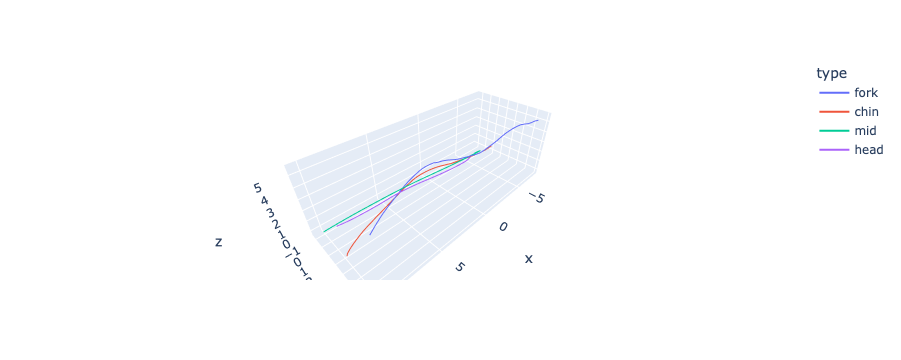

In [780]:
import plotly.express as px
data = pd.DataFrame({"x":np.concatenate([ms_fork[:,0],ms_chin[:,0],ms_mid[:,0],ms_head[:,0]]),"y":np.concatenate([ms_fork[:,1],ms_chin[:,1],ms_mid[:,1],ms_head[:,1]]),"z":np.concatenate([ms_fork[:,2],ms_chin[:,2], ms_mid[:,2], ms_head[:,2]]), "type":["fork" for i in range(51)]+["chin" for i in range(51)]+["mid" for i in range(51)]+["head" for i in range(51)]})
fig = px.line_3d(data, x='x', y='y', z='z', color='type')
fig.show()

For $t$ frame, $j,k$ bodyparts, want $\sum_{t,j,k} \lambda (||q_{t,j}-q_{t,k}||_2 - L_{j,k})^2$ for limb loss. 
Define $L_{j,k}$ from labeled dataset with $\tilde{y}$, use PCA to get $B_j$ and $B_k$ where $q_{t,j} = B_j \tilde{y}_{t,j}$, $q_{t,k}= B_k \tilde{y}_{t,k}$ from PCA and $L_{j,k} = ||B_j^T \tilde{y}_{t,j}-B_k^T \tilde{y}_{t,k}||_2$ then in EKS limb loss would be $\sum_{t,j,k} \lambda (||q_{t,j}-q_{t,k}||_2 - L_{j,k})^2 =\sum_{t,j,k} \lambda (||q_{t,j}-q_{t,k}||_2 - ||B_j^T \tilde{y}_{t,j}-B_k^T \tilde{y}_{t,k}||_2)^2 $

In [781]:
labeled_markers = []
part = ['fork_main', 'fork_right', 'fork_top']
for i in range(len(part)):
    data = pd.DataFrame(lab_points["rick"][[part[i]]]).T.reset_index(drop=True)
    data.columns=[col[0] + "_" + col[1] for col in data.columns]
    labeled_markers.append([data])

Get the observation from labeled set.

In [782]:
labeled_markers = []
for part in bodyparts:
    if 'fork' in part:
        labeled_markers.append(lab_points["rick"][part].tolist())
labeled_markers = np.asarray(labeled_markers).flatten()

Remove camera means

In [783]:
def get_means_from_multicam(keypoint_ensemble, camera_names, quantile_keep_pca = 50):
    num_cameras = len(camera_names)
    markers_list_cameras = [[] for i in range(num_cameras)]
    for m in markers_list:
        for camera in range(num_cameras):
            markers_list_cameras[camera].append(
                m[[key for key in m.keys() 
                   if camera_names[camera] in key 
                   and 'likelihood' not in key 
                   and keypoint_ensemble in key]
                 ]
            )

    markers_list_stacked_interp = []
    markers_list_interp = [[] for i in range(num_cameras)]
    for model_id in range(len(markers_list_cameras[0])):
        bl_markers_curr = []
        camera_markers_curr = [[] for i in range(num_cameras)]
        for i in range(markers_list_cameras[0][0].shape[0]):
            curr_markers = []
            for camera in range(num_cameras):
                markers = np.array(markers_list_cameras[camera][model_id].to_numpy()[i, [0, 1]])
                camera_markers_curr[camera].append(markers)
                curr_markers.append(markers)
            bl_markers_curr.append(np.concatenate(curr_markers)) #combine predictions for both cameras
        markers_list_stacked_interp.append(bl_markers_curr)
        for camera in range(num_cameras):
            markers_list_interp[camera].append(camera_markers_curr[camera])
    markers_list_stacked_interp = np.asarray(markers_list_stacked_interp)
    markers_list_interp = np.asarray(markers_list_interp)

    keys = [keypoint_ensemble+'_x', keypoint_ensemble+'_y']
    markers_list_cams = [[] for i in range(num_cameras)]
    for k in range(len(markers_list_interp[0])):
        for camera in range(num_cameras):
            markers_cam = pd.DataFrame(markers_list_interp[camera][k], columns = keys)
            markers_list_cams[camera].append(markers_cam)
    #compute ensemble median for each camera
    cam_ensemble_preds = []
    cam_ensemble_vars = []

    for camera in range(num_cameras):
        cam_ensemble_preds_curr, cam_ensemble_vars_curr, cam_ensemble_stacks_curr, cam_keypoints_mean_dict_curr, cam_keypoints_var_dict_curr, cam_keypoints_stack_dict_curr = ensemble(markers_list_cams[camera], keys)
        cam_ensemble_preds.append(cam_ensemble_preds_curr)
        cam_ensemble_vars.append(cam_ensemble_vars_curr)

    #filter by low ensemble variances
    hstacked_vars = np.hstack(cam_ensemble_vars)
    max_vars = np.max(hstacked_vars,1)
    quantile_keep = quantile_keep_pca
    good_frames = np.where(max_vars <= np.percentile(max_vars, quantile_keep))[0]

    good_cam_ensemble_preds = []
    for camera in range(num_cameras):
        good_cam_ensemble_preds.append(cam_ensemble_preds[camera][good_frames])

    good_ensemble_preds = np.hstack(good_cam_ensemble_preds)
    means_camera = []
    for i in range(good_ensemble_preds.shape[1]):
        means_camera.append(good_ensemble_preds[:,i].mean())
    return means_camera
means_camera = get_means_from_multicam('fork', camera_names, quantile_keep_pca = 50)

In [784]:
def get_labeled_latent(keypoint_ensemble, camera_names, quantile_keep_pca = 50):
    means_camera = get_means_from_multicam(keypoint_ensemble, camera_names, quantile_keep_pca = 50)
    labeled_markers = []
    for part in bodyparts:
        if keypoint_ensemble in part:
            labeled_markers.append(lab_points["rick"][part].tolist())
    labeled_markers = np.asarray(labeled_markers).flatten()
    y_lab = labeled_markers - means_camera
    
    _, ensemble_pca, _, _ = get_pca_from_part(keypoint_ensemble, camera_names, quantile_keep_pca)
    
    return y_lab,  np.dot(y_lab, ensemble_pca.components_.T)

In [785]:
y_head, q_head = get_labeled_latent("head", camera_names, quantile_keep_pca = 50)
y_chin, q_chin = get_labeled_latent("chin_base", camera_names, quantile_keep_pca = 50)
y_fork, q_fork = get_labeled_latent("fork", camera_names, quantile_keep_pca = 50)
y_mid, q_mid = get_labeled_latent("mid", camera_names, quantile_keep_pca = 50)

filtering head...
done filtering
smoothing head...
done smoothing
filtering chin_base...
done filtering
smoothing chin_base...
done smoothing
filtering fork...
done filtering
smoothing fork...
done smoothing
filtering mid...
done filtering
smoothing mid...
done smoothing


array([-86.00350037,  64.9738174 ,  44.60448108])

In [719]:
y

array([ 18.14564079, -27.21644404, -10.13575091])

<Axes: >

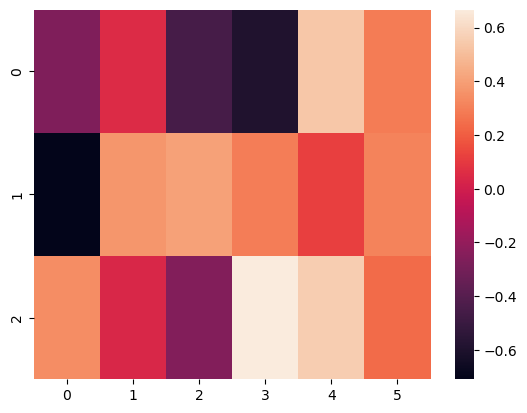

<Axes: >

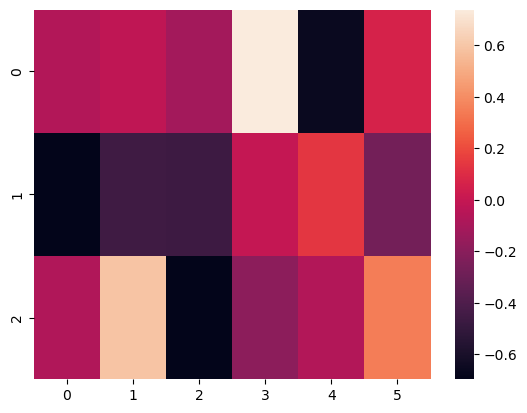

In [516]:
sns.heatmap(ensemble_pca_chin.components_)

In [425]:
camera_dfs

{'main_df': scorer    ensemble-kalman_tracker                       
 bodyparts                    fork                       
 coords                          x           y likelihood
 0                      137.069918  323.288542        NaN
 1                      137.045447  323.283121        NaN
 2                      136.996424  323.261215        NaN
 3                      136.919226  323.224451        NaN
 4                      136.829857  323.162013        NaN
 5                      136.749982  323.056576        NaN
 6                      136.627972  322.953041        NaN
 7                      136.436734  322.871670        NaN
 8                      136.244444  322.773012        NaN
 9                      136.129617  322.612833        NaN
 10                     136.041454  322.421666        NaN
 11                     135.987025  322.204202        NaN
 12                     135.972156  321.958917        NaN
 13                     136.008429  321.677833        NaN
 14

In [407]:
len(bodyparts)

45